# Essais et développement de la méthode de calage sur marges

# Imports

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import unittest

import pandas as pd

tc = unittest.TestCase()

In [ ]:
import logging
import operator

import seaborn as sns
from leximpact_common_python_libraries.config import Configuration
from matplotlib import pyplot as plt
from numpy import array, dot, exp, float64, ones, unique, zeros

config = Configuration(project_folder="leximpact-prepare-data")
log = logging.getLogger(__name__)

# Code issu de survey_manager

In [ ]:
def linear(u):
    """

    Args:
      u:

    Returns:

    """
    return 1 + u

In [ ]:
def linear_prime(u):
    """

    Args:
      u:

    Returns:

    """
    return ones(u.shape, dtype=float)

In [ ]:
def raking_ratio(u):
    """

    Args:
      u:

    Returns:

    """
    return exp(u)

In [ ]:
def raking_ratio_prime(u):
    """

    Args:
      u:

    Returns:

    """
    return exp(u)

In [ ]:
def logit(u, low, up):
    """

    Args:
      u:
      low:
      up:

    Returns:

    """
    a = (up - low) / ((1 - low) * (up - 1))
    return (low * (up - 1) + up * (1 - low) * exp(a * u)) / (
        up - 1 + (1 - low) * exp(a * u)
    )

In [ ]:
def logit_prime(u, low, up):
    """

    Args:
      u:
      low:
      up:

    Returns:

    """
    a = (up - low) / ((1 - low) * (up - 1))
    return (
        (a * up * (1 - low) * exp(a * u)) * (up - 1 + (1 - low) * exp(a * u))
        - (low * (up - 1) + up * (1 - low) * exp(a * u)) * (1 - low) * a * exp(a * u)
    ) / (up - 1 + (1 - low) * exp(a * u)) ** 2

In [ ]:
def build_dummies_dict(data):
    """

    Args:
      data:

    Returns:


    """
    unique_val_list = unique(data)
    output = {}
    for val in unique_val_list:
        output[val] = data == val
    return output

In [ ]:
def calmar(
    data_in,
    margins,
    initial_weight="wprm_init",
    method="linear",
    lo=None,
    up=None,
    use_proportions=False,
    xtol=1.49012e-08,
    maxfev=256,
):
    """Calibrates weights to satisfy margins constraints

    Args:
        data_in (pd.DataFrame): The observations data
        margins (dict): Margins is a dictionnary containing for each variable as key the following values
          - a scalar for numeric variables
          - a dictionnary with categories as key and populations as values
          - eventually a key named `total_population` with value the total population. If absent it is initialized to the actual total population
        initial_weight (str, optional): Initial weight variable. Defaults to 'wprm_init'.
        method (str, optional): Calibration method. Should be 'linear', 'raking ratio' or 'logit'. Defaults to 'linear'.
        lo (float, optional): Lower bound on weights ratio. Mandatory when using logit method. Should be < 1. Defaults to None.
        up (float, optional): Upper bound on weights ratio. Mandatory when using logit method. Should be > 1. Defaults to None.
        use_proportions (bool, optional): When True use proportions if total population from margins doesn't match total population. Defaults to False.
        xtol (float, optional): Relative precision on lagrangian multipliers.  Defaults to 1.49012e-08 (fsolve xtol).
        maxfev (int, optional): Maximum number of function evaluation. Defaults to 256.

    Raises:
        Exception: [description]
        Exception: [description]
        Exception: [description]

    Returns:
        np.array: Margins adjusting weights
        float: Lagrangian parameter
        dict: Updated margins
    """
    from scipy.optimize import fsolve

    # remove null weights and keep original data
    null_weight_observations = data_in[initial_weight].isnull().sum()
    if null_weight_observations > 0:
        log.info(
            "{} observations have a NaN weight. Not used in the calibration.".format(
                null_weight_observations
            )
        )

    is_non_zero_weight = data_in[initial_weight].fillna(0) > 0
    if is_non_zero_weight.sum() > null_weight_observations:
        log.info(
            "{} observations have a zero weight. Not used in the calibration.".format(
                (data_in[initial_weight].fillna(0) <= 0).sum()
                - null_weight_observations
            )
        )

    variables = set(margins.keys()).intersection(set(data_in.columns))
    for variable in variables:
        null_value_observations = data_in[variable].isnull().sum()
        if null_value_observations > 0:
            log.info(
                "For variable {}, {} observations have a NaN value. Not used in the calibration.".format(
                    variable, null_value_observations
                )
            )
            is_non_zero_weight = is_non_zero_weight & data_in[variable].notnull()

    if not is_non_zero_weight.all():
        log.info(f"We drop {(~is_non_zero_weight).sum()} observations.")

    data = dict()
    for a in data_in.columns:
        data[a] = data_in.loc[is_non_zero_weight, a].copy()

    if not margins:
        raise Exception("Calmar requires non empty dict of margins")

    # choose method
    assert method in [
        "linear",
        "raking ratio",
        "logit",
    ], "method should be 'linear', 'raking ratio' or 'logit'"
    if method == "linear":
        F = linear
        F_prime = linear_prime
    elif method == "raking ratio":
        F = raking_ratio
        F_prime = raking_ratio_prime
    elif method == "logit":
        assert up is not None, "When method == 'logit', a value > 1 for up is mandatory"
        assert up > 1, "up should be > 1"
        assert lo is not None, "When method == 'logit', a value < 1 for lo is mandatory"
        assert lo < 1, "lo should be < 1"

        def F(x):
            return logit(x, lo, up)

        def F_prime(x):
            return logit_prime(x, lo, up)

    # Construction observations matrix
    if "total_population" in margins:
        print(
            "On utilise un total de population pour calibrer, qui est de : ",
            margins["total_population"],
            "foyers",
        )
        total_population = margins.pop("total_population")
    else:
        print("On n'a pas donné de total de population pour la calibration")
        total_population = data[initial_weight].fillna(0).sum()

    nk = len(data[initial_weight])
    # number of Lagrange parameters (at least total population)
    nj = 1

    margins_new = {}
    margins_new_dict = {}
    for var, val in margins.items():
        if isinstance(val, dict):
            dummies_dict = build_dummies_dict(data[var])
            k, pop = 0, 0
            for cat, nb in val.items():
                cat_varname = var + "_" + str(cat)
                data[cat_varname] = dummies_dict[cat]
                margins_new[cat_varname] = nb
                if var not in margins_new_dict:
                    margins_new_dict[var] = {}
                margins_new_dict[var][cat] = nb
                pop += nb
                k += 1
                nj += 1
            # Check total population
            if pop != total_population:
                if use_proportions:
                    log.info(
                        "calmar: categorical variable {} is inconsistent with population; using proportions".format(
                            var
                        )
                    )
                    for cat, nb in val.items():
                        cat_varname = var + "_" + str(cat)
                        margins_new[cat_varname] = nb * total_population / pop
                        margins_new_dict[var][cat] = nb * total_population / pop
                else:
                    raise Exception(
                        "calmar: categorical variable {} weights sums up to {} != {}".format(
                            var, pop, total_population
                        )
                    )
        else:
            margins_new[var] = val
            margins_new_dict[var] = val
            nj += 1

    # On conserve systematiquement la population
    if hasattr(data, "dummy_is_in_pop"):
        raise Exception("dummy_is_in_pop is not a valid variable name")

    data["dummy_is_in_pop"] = ones(nk)
    margins_new["dummy_is_in_pop"] = total_population

    # paramètres de Lagrange initialisés à zéro
    lambda0 = zeros(nj)

    # initial weights
    d = data[initial_weight].values
    x = zeros((nk, nj))  # nb obs x nb constraints
    xmargins = zeros(nj)
    margins_dict = {}
    j = 0
    for var, val in margins_new.items():
        x[:, j] = data[var]
        xmargins[j] = val
        margins_dict[var] = val
        j += 1

    # Résolution des équations du premier ordre
    def constraint(lambda_):
        return dot(d * F(dot(x, lambda_)), x) - xmargins

    def constraint_prime(lambda_):
        return dot(d * (x.T * F_prime(dot(x, lambda_))), x)
        # le jacobien ci-dessus est constraintprime = @(lambda) x*(d.*Fprime(x'*lambda)*x');

    tries, ier = 0, 2
    err_max = 1
    conv = 1
    while (ier == 2 or ier == 5 or ier == 4) and not (
        tries >= 10 or (err_max < 1e-6 and conv < 1e-8)
    ):
        lambdasol, infodict, ier, mesg = fsolve(
            constraint,
            lambda0,
            fprime=constraint_prime,
            maxfev=maxfev,
            xtol=xtol,
            full_output=1,
        )
        lambda0 = 1 * lambdasol
        tries += 1

        pondfin = d * F(dot(x, lambdasol))
        rel_error = {}
        for var, val in margins_new.items():  # noqa analysis:ignore
            rel_error[var] = (
                abs((data[var] * pondfin).sum() - margins_dict[var]) / margins_dict[var]
            )
        sorted_err = sorted(rel_error.items(), key=operator.itemgetter(1), reverse=True)

        conv = abs(err_max - sorted_err[0][1])
        err_max = sorted_err[0][1]

    if ier == 2 or ier == 5 or ier == 4:
        log.debug(f"optimization converged after {tries} tries")

    # rebuilding a weight vector with the same size of the initial one
    pondfin_out = array(data_in[initial_weight], dtype=float64)
    pondfin_out[is_non_zero_weight] = pondfin
    print("pondfin somme", pondfin.sum())

    del infodict, mesg  # TODO better exploit this information

    return pondfin_out, lambdasol, margins_new_dict

In [ ]:
def check_calmar(
    data_in,
    margins,
    initial_weight="wprm_init",
    pondfin_out=None,
    lambdasol=None,
    margins_new_dict=None,
):
    """

    Args:
      data_in:
      margins:
      initial_weight:  (Default value = 'wprm_init')
      pondfin_out:  (Default value = None)
      lambdasol:  (Default value = None)
      margins_new_dict:  (Default value = None)

    Returns:

    """

    for variable, margin in margins.items():
        if variable != "total_population":
            print(
                "margin",
                margin,
                "margins_new_dict[variable]",
                margins_new_dict[variable],
            )
            print(
                variable,
                "Total attendu : ",
                margin,
                "Erreur : ",
                abs(margin - margins_new_dict[variable]) / abs(margin),
                "%",
            )

# Essais

## Génération d'un échantillon

In [ ]:
# Import de la base ERFS et sélection d'un échantillon
erfs_03 = pd.read_hdf(
    config.get("DATA_OUT") + "03_erfs_rfr_cal_ind" + config.get("YEAR_ERFS") + ".h5"
)
erfs_03.columns
erfs_03.tail()

Index(['activite', 'age', 'categorie_salarie', 'chomage_brut',
       'contrat_de_travail', 'date_naissance', 'effectif_entreprise',
       'heures_remunerees_volume', 'idfam', 'idfoy', 'idmen', 'noindiv',
       'pensions_alimentaires_percues', 'quifam', 'quifoy', 'quimen', 'rag',
       'retraite_brute', 'ric', 'rnc', 'statut_marital', 'salaire_de_base',
       'idmen_original', 'idfoy_original', 'idfam_original', 'idmen_x', 'wprm',
       'zone_apl', 'fake_id', 'f4ba', 'quimenof', 'quifoyof', 'quifamof',
       'rfr'],
      dtype='object')

activite  age  categorie_salarie  chomage_brut  contrat_de_travail  \
337803       0.0   51                  1             0                   0   
337804       0.0   44                  1             0                   0   
337805       0.0   80                  1             0                   0   
337806       0.0   66                  0             0                   1   
337807       0.0   62                  0             0                   0   

       date_naissance  effectif_entreprise  heures_remunerees_volume   idfam  \
337803     1966-01-14                   50                       0.0  172206   
337804     1973-01-14                  500                       0.0  172207   
337805     1937-10-04                   50                       0.0  172208   
337806     1951-01-04                    0                    1144.0  172209   
337807     1955-04-17                  500                       0.0  172210   

         idfoy  ...  idfam_original   idmen_x      wprm  zone_apl  fake_id  \
337803  172206  ...      1802957401  18011370  0.668483         2      1.0   
337804  172207  ...      1801891601  18028481  0.989284         2      1.0   
337805  172208  ...      1803209401  18019488  0.693574         2      1.0   
337806  172209  ...      1804042701  18011185  0.885337         2      1.0   
337807  172210  ...      1803086002  18038170  0.793936         2      1.0   

            f4ba               quimenof             quifoyof   quifamof  \
337803    4399.0  personne_de_reference  declarant_principal  demandeur   
337804    1500.0  personne_de_reference  declarant_principal  demandeur   
337805       0.0  personne_de_reference  declarant_principal  demandeur   
337806  139340.0  personne_de_reference  declarant_principal  demandeur   
337807       0.0  personne_de_reference  declarant_principal  demandeur   

                 rfr  
337803  3.186688e+07  
337804  4.977271e+07  
337805  9.158978e+07  
337806  6.888963e+07  
337807  5.150487e+07  

[5 rows x 34 columns]

In [ ]:
# Notre échantillon pour tests
dataset = erfs_03[
    [
        "idfoy",
        "quifoy",
        "wprm",
        "salaire_de_base",
        "chomage_brut",
        "retraite_brute",
        "f4ba",
        "rfr",
    ]
]

# Pour tester sur une partie de la base
# dataset = dataset.sample(n=1000, random_state=53)
print("On a ", len(dataset), "individus dans cet échantillon")

# Ici, wprm sont les poids initiaux dits "de sondage"
dataset.rename(columns={"wprm": "wprm_init"}, inplace=True)
wprm_init = dataset["wprm_init"]

dataset.head()

On a  337808 individus dans cet échantillon


/home/jupyter-sasha/.cache/pypoetry/virtualenvs/leximpact_prepare_data-77FW3yLw-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


idfoy  quifoy   wprm_init  salaire_de_base  chomage_brut  retraite_brute  \
0      0       0  272.745914         0.000000             0            3560   
1      1       0  227.157260         0.000000             0           19360   
2      1       1  227.157260         0.000000             0           28230   
3      2       0  194.930798     65283.748389             0               0   
4      2       1  194.930798     29200.808225             0               0   

    f4ba           rfr  
0    0.0    755.000244  
1    0.0  43778.000000  
2    0.0      0.000000  
3  550.0  70192.570312  
4    0.0      0.000000

In [ ]:
# Nos variables auxilliaires sont: le salaire_de_base, le chomage_brut, la retraite_brute et le f4ba (revenu foncier)
margins_avant = {}

margins_avant.update(
    {
        "salaire_de_base": (dataset["wprm_init"] * dataset["salaire_de_base"]).sum(),
        "chomage_brut": (dataset["wprm_init"] * dataset["chomage_brut"]).sum(),
        "retraite_brute": (dataset["wprm_init"] * dataset["retraite_brute"]).sum(),
        "f4ba": (dataset["wprm_init"] * dataset["f4ba"]).sum(),
    }
)

margins_avant

{'salaire_de_base': 787347859186.1661,
 'chomage_brut': 35973091573.96126,
 'retraite_brute': 425467165630.34125,
 'f4ba': 44012929315.33398}

In [ ]:
# On vérifie qu'on n'a pas de Nans
tc.assertEqual(dataset.isna().sum().sum(), 0)

# Si c'est le cas, on pourra les enlever:
# dataset = dataset.fillna(0) ou dataset = dataset.dropna(0)

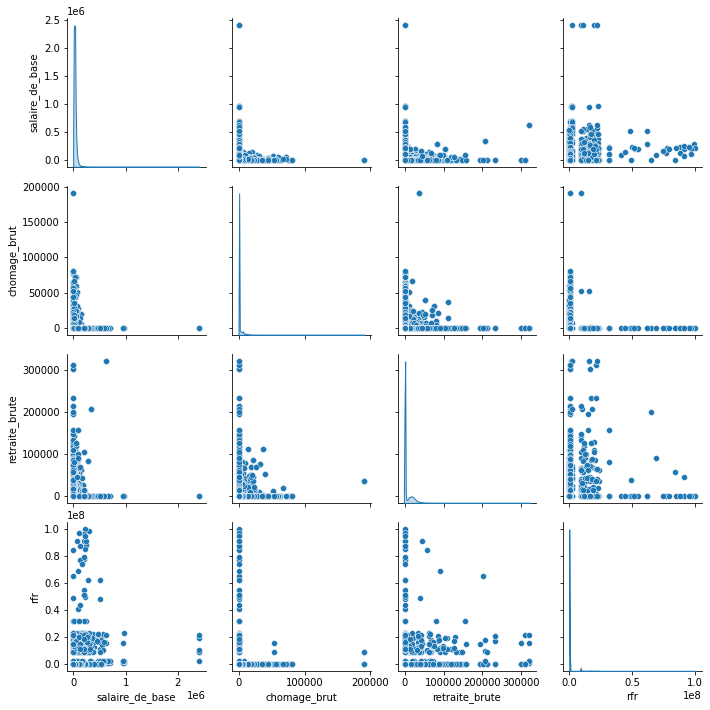

In [ ]:
# On observe nos données
sns.pairplot(
    dataset[["salaire_de_base", "chomage_brut", "retraite_brute", "rfr"]],
    diag_kind="kde",
)

TODO: voir si on fait une normalization

## Calage sur marges

### Marges

In [ ]:
# Pour calibrer, on introduit les totaux "wanted"  ( TODO: à paramétriser)
margins = {}
margins.update(
    {
        "salaire_de_base": 650855163531.0,  # Salaire imposable POTE 2019
        "chomage_brut": 0.97
        * (
            dataset["wprm_init"] * dataset["chomage_brut"]
        ).sum(),  # On ne connait pas le chiffre, donc on met un ecart pour calibrer
        "retraite_brute": 307254581479.0,  # Retraite POTE 2019
        "f4ba": 1.34 * (dataset["wprm_init"] * dataset["f4ba"]).sum(),
    }
)  # On ne connait pas le chiffre, donc on met un ecart pour calibrer

# On ajoute une limite de population
margins.update({"total_population": 38549926})
margins

{'salaire_de_base': 650855163531.0,
 'chomage_brut': 34893898826.74242,
 'retraite_brute': 307254581479.0,
 'f4ba': 58977325282.54753,
 'total_population': 38549926}

### Calage

Calibrates weights to satisfy margins constraints

Args:
- data_in (pd.DataFrame): The observations data
- margins (dict): Margins is a dictionnary containing for each variable as key the following values
    - a scalar for numeric variables
    - a dictionnary with categories as key and populations as values
    - eventually a key named `total_population` with value the total population. If absent it is initialized to the actual total population
- initial_weight (str, optional): Initial weight variable. Defaults to 'wprm_init'.
- method (str, optional): Calibration method. Should be 'linear', 'raking ratio' or 'logit'. Defaults to 'linear'.
- lo (float, optional): Lower bound on weights ratio. Mandatory when using logit method. Should be < 1. Defaults to None.
- up (float, optional): Upper bound on weights ratio. Mandatory when using logit method. Should be > 1. Defaults to None.
- use_proportions (bool, optional): When True use proportions if total population from margins doesn't match total population. Defaults to False.
- xtol (float, optional): Relative precision on lagrangian multipliers.  Defaults to 1.49012e-08 (fsolve xtol).
- maxfev (int, optional): Maximum number of function evaluation. Defaults to 256.

In [ ]:
# Calage
pondfin_out, lambdasol, margins_new_dict = calmar(
    dataset,
    margins,
    initial_weight="wprm_init",
    method="raking ratio",
    lo=0.33,
    up=3,
    use_proportions=False,
    xtol=1.49012e-08,
    maxfev=256,
)

# pondfin_out
# lambdasol
# margins_new_dict

### Analyse
On va maintenant regarder l'évolution des distributions avant et après la pondération

In [ ]:
# Nos variables d'intérêts
variables = ["salaire_de_base", "chomage_brut", "retraite_brute"]

In [ ]:
# | export


def compute_dataset_pondere(dataset, wprm, type_cal):
    data_pond = dataset.copy()
    for variable in dataset.columns:
        data_pond[variable] = data_pond[variable] * wprm

    data_pond["wprm"] = wprm
    data_pond["type"] = type_cal
    return data_pond

In [ ]:
# | export


def analyse_calage(dataset, margins, pondfin_out, lambdasol, margins_new_dict):
    # Resultat sur les marges
    check_calmar(
        dataset,
        margins,
        initial_weight="wprm_init",
        pondfin_out=pondfin_out,
        lambdasol=lambdasol,
        margins_new_dict=margins_new_dict,
    )

    # Données pondérées après calage
    data_cal_pond = compute_dataset_pondere(dataset, pondfin_out, "cal")

    # Analyse
    sns.pairplot(
        data_cal_pond,
        diag_kind="kde",
    )
    plt.show()

salaire_de_base Total attendu :  650855163531.0 Erreur :  0.0
chomage_brut Total attendu :  34893898826.74242 Erreur :  0.0
retraite_brute Total attendu :  307254581479.0 Erreur :  0.0
f4ba Total attendu :  58977325282.54753 Erreur :  0.0


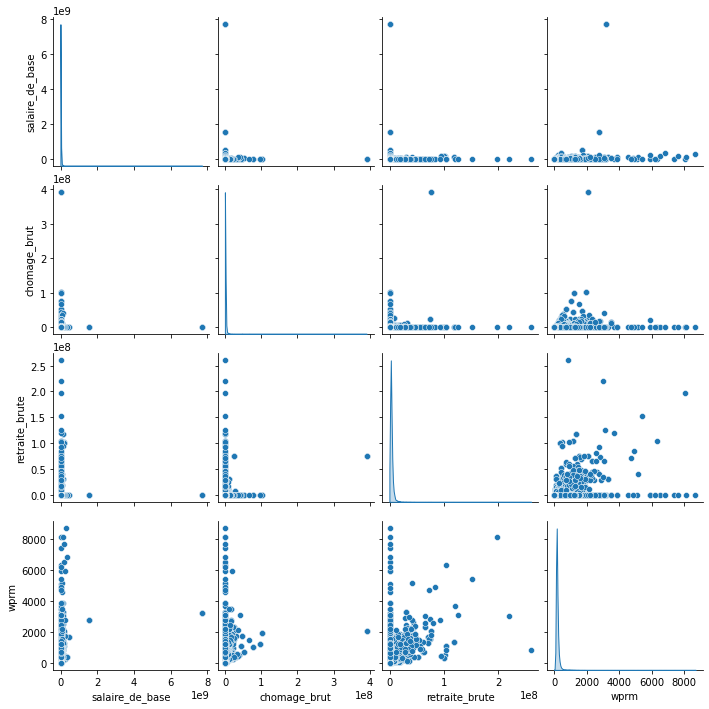

In [ ]:
# On analyse la calibration
analyse_calage(dataset[variables], pondfin_out)

## Comparer les méthodes de calibration

### Differents calages

Calibrates weights to satisfy margins constraints

Args:
- data_in (pd.DataFrame): The observations data
- margins (dict): Margins is a dictionnary containing for each variable as key the following values
    - a scalar for numeric variables
    - a dictionnary with categories as key and populations as values
    - eventually a key named `total_population` with value the total population. If absent it is initialized to the actual total population
- initial_weight (str, optional): Initial weight variable. Defaults to 'wprm_init'.
- method (str, optional): Calibration method. Should be 'linear', 'raking ratio' or 'logit'. Defaults to 'linear'.
- lo (float, optional): Lower bound on weights ratio. Mandatory when using logit method. Should be < 1. Defaults to None.
- up (float, optional): Upper bound on weights ratio. Mandatory when using logit method. Should be > 1. Defaults to None.
- use_proportions (bool, optional): When True use proportions if total population from margins doesn't match total population. Defaults to False.
- xtol (float, optional): Relative precision on lagrangian multipliers.  Defaults to 1.49012e-08 (fsolve xtol).
- maxfev (int, optional): Maximum number of function evaluation. Defaults to 256.

salaire_de_base Total attendu :  650855163531.0 Erreur :  0.0
chomage_brut Total attendu :  34893898826.74242 Erreur :  0.0
retraite_brute Total attendu :  307254581479.0 Erreur :  0.0
f4ba Total attendu :  58977325282.54753 Erreur :  0.0


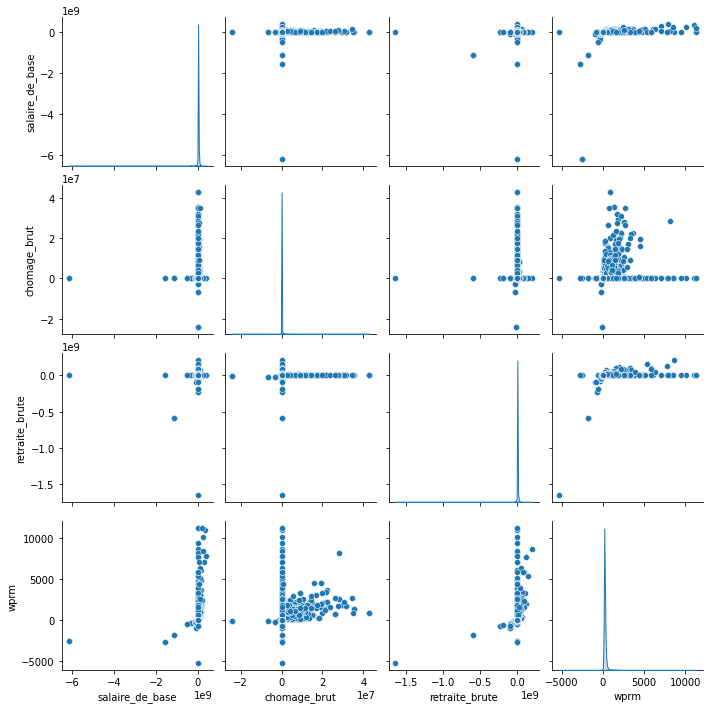

In [ ]:
# Lineaire
pondfin_lin, lambdasol, margins_new_dict = calmar(
    dataset,
    margins,
    initial_weight="wprm_init",
    method="linear",
    lo=0,
    up=3,
    use_proportions=False,
    xtol=1.49012e-08,
    maxfev=256,
)

analyse_calage(dataset[variables], pondfin_lin)

salaire_de_base Total attendu :  650855163531.0 Erreur :  0.0
chomage_brut Total attendu :  34893898826.74242 Erreur :  0.0
retraite_brute Total attendu :  307254581479.0 Erreur :  0.0
f4ba Total attendu :  58977325282.54753 Erreur :  0.0


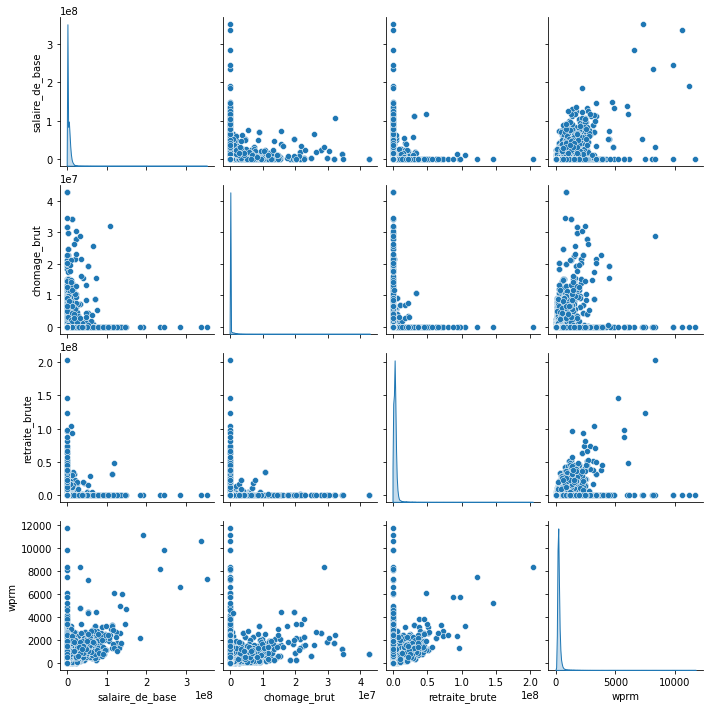

In [ ]:
# Raking ratio
pondfin_rr, lambdasol, margins_new_dict = calmar(
    dataset,
    margins,
    initial_weight="wprm_init",
    method="raking ratio",
    lo=0,
    up=3,
    use_proportions=False,
    xtol=1.49012e-08,
    maxfev=256,
)

analyse_calage(dataset[variables], pondfin_rr)

salaire_de_base Total attendu :  650855163531.0 Erreur :  0.0
chomage_brut Total attendu :  34893898826.74242 Erreur :  0.0
retraite_brute Total attendu :  307254581479.0 Erreur :  0.0
f4ba Total attendu :  58977325282.54753 Erreur :  0.0


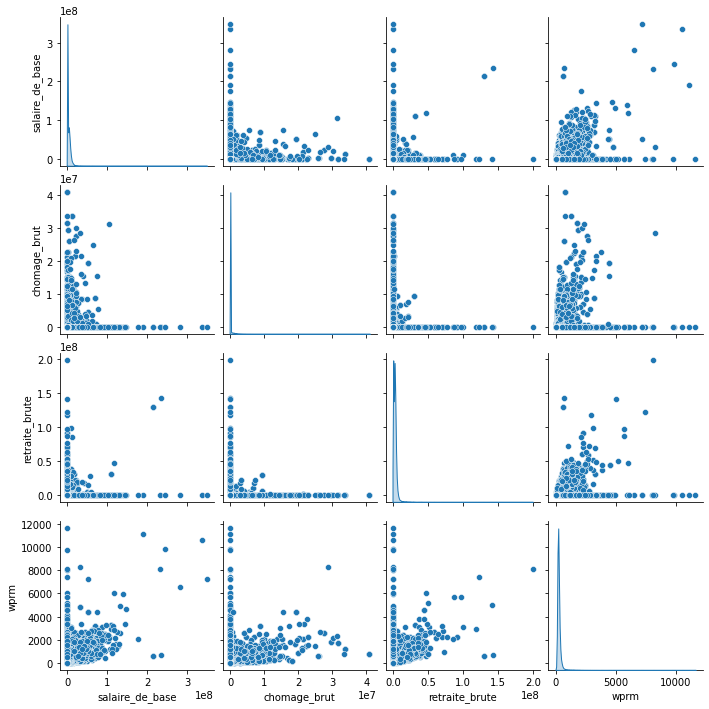

In [ ]:
# Logit
pondfin_log, lambdasol, margins_new_dict = calmar(
    dataset,
    margins,
    initial_weight="wprm_init",
    method="logit",
    lo=0,
    up=3,
    use_proportions=False,
    xtol=1.49012e-08,
    maxfev=256,
)

analyse_calage(dataset[variables], pondfin_log)

### Check des distributions selon la calibration

In [ ]:
def matrice_violin(dataset, results):
    # Initial
    data_init_pond = compute_dataset_pondere(
        dataset[variables], dataset["wprm_init"], "init"
    )
    matrix = data_init_pond.copy()
    # Pour chaque calibration on concatene dans une matrice
    for cal in results:
        data_cal_pond = compute_dataset_pondere(dataset[variables], results[cal], cal)
        matrix = pd.concat([matrix, data_cal_pond])  # .reset_index()

    return matrix

In [ ]:
# On créé une matrice avec toutes les calibrations:
results = {}
results.update(
    {"linear": pondfin_lin, "raking_ratio": pondfin_rr, "logit": pondfin_log}
)

len(dataset)
matrix = matrice_violin(dataset, results)
len(matrix)
matrix.head()
matrix.tail()

337808

1351232

salaire_de_base  chomage_brut  retraite_brute        wprm  type
0     0.000000e+00           0.0    9.709755e+05  272.745914  init
1     0.000000e+00           0.0    4.397765e+06  227.157260  init
2     0.000000e+00           0.0    6.412649e+06  227.157260  init
3     1.272581e+07           0.0    0.000000e+00  194.930798  init
4     5.692137e+06           0.0    0.000000e+00  194.930798  init

salaire_de_base  chomage_brut  retraite_brute      wprm   type
337803     39687.862953           0.0        0.000000  0.384804  logit
337804     37085.515568           0.0        0.000000  0.161205  logit
337805     11703.527279           0.0     6944.512336  0.154494  logit
337806    104812.357635           0.0    99895.022856  1.115024  logit
337807     32395.823827           0.0        0.000000  0.156183  logit

<AxesSubplot:ylabel='salaire_de_base'>

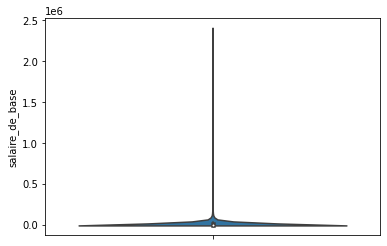

<AxesSubplot:ylabel='chomage_brut'>

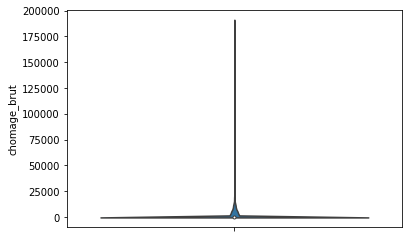

<AxesSubplot:ylabel='retraite_brute'>

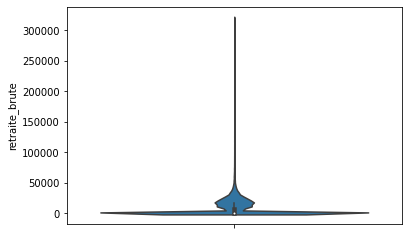

In [ ]:
# On trace toutes les distributions AVANT
for var in variables:
    sns.violinplot(data=dataset, y=var)
    plt.show()

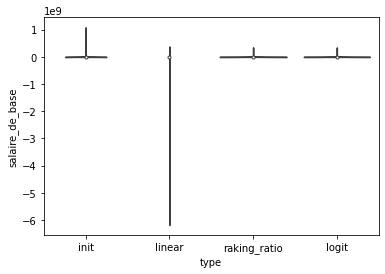

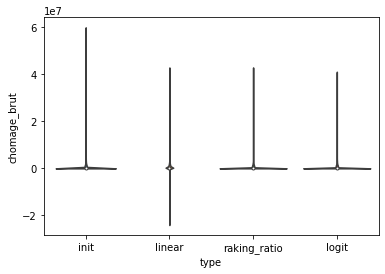

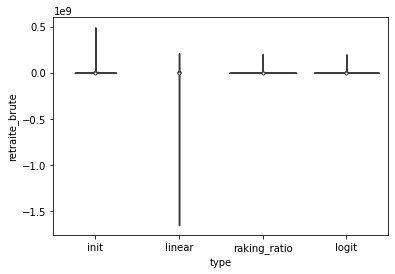

In [ ]:
# On trace toutes les distributions APRES
for var in variables:
    ax = sns.violinplot(data=matrix, y=var, x="type", split=True)
    plt.show()

#### Linear Calibration

On voit bien qu'elle détonne. Je suis étonnée des résultats négatifs...

In [ ]:
min(results["linear"])

-5312.959943437512

In [ ]:
# On supprime ce plot
results2 = results.copy()
results2.pop("linear")
results2

array([2.92461829e+02, 1.91694652e+02, 1.62567893e+02, ...,
       8.70919985e-02, 6.96777702e-01, 1.34821656e-01])

{'raking_ratio': array([2.97926424e+02, 1.84566932e+02, 1.56315404e+02, ...,
        2.04660894e-01, 1.26721690e-01, 2.15081686e-01]),
 'logit': array([2.97286024e+02, 1.82753723e+02, 1.51461619e+02, ...,
        1.54494157e-01, 1.11502425e+00, 1.56182765e-01])}

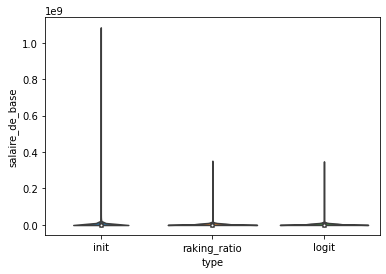

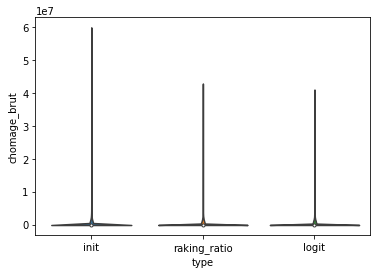

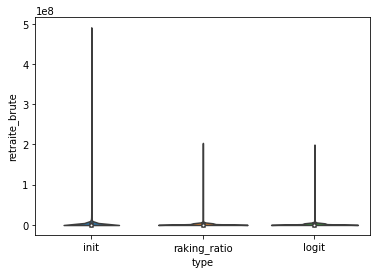

In [ ]:
# On créé une matrice avec toutes les calibrations:
matrix2 = matrice_violin(dataset, results2)

# On trace les distributions APRES
for var in variables:
    ax = sns.violinplot(data=matrix2, y=var, x="type", split=True)
    plt.show()

### Analyse de la prédiction

#### Marges

In [ ]:
margins

{'salaire_de_base': 650855163531.0,
 'chomage_brut': 34893898826.74242,
 'retraite_brute': 307254581479.0,
 'f4ba': 58977325282.54753}

In [ ]:
for var in variables:
    print(var)
    tot_rr = (dataset[var] * results2["raking_ratio"]).sum()
    tot_log = (dataset[var] * results2["logit"]).sum()

    error_rr = abs(tot_rr - margins[var]) / margins[var]
    error_log = abs(tot_log - margins[var]) / margins[var]

    print("Total initial", (dataset[var] * dataset["wprm_init"]).sum())
    print("Total Raking Ratio", tot_rr, ", erreur : ", error_rr)
    print("Total Logit", tot_log, ", erreur : ", error_log, "\n")

salaire_de_base
Total initial 787347859186.1661
Total Raking Ratio 650855163532.2374 , erreur :  1.9012321437218833e-12
Total Logit 650855163526.8951 , erreur :  6.306869221360932e-12 

chomage_brut
Total initial 35973091573.96126
Total Raking Ratio 34893898826.89992 , erreur :  4.51371804237643e-12
Total Logit 34893898812.17035 , erreur :  4.176107500367447e-10 

retraite_brute
Total initial 425467165630.34125
Total Raking Ratio 307254581478.8941 , erreur :  3.4465229317007825e-13
Total Logit 307254581500.65814 , erreur :  7.04892405040477e-11 



#### Prédictions

In [ ]:
# RFR
tot_rr = (dataset["rfr"] * results2["raking_ratio"]).sum()
tot_log = (dataset["rfr"] * results2["logit"]).sum()
print("Total initial", (dataset["rfr"] * dataset["wprm_init"]).sum())
print("Total Raking Ratio", tot_rr)
print("Total Logit", tot_log)

Total initial 1082742031730.5735
Total Raking Ratio 873176715920.9836
Total Logit 850180013352.238


## Observation de distributions pondérées

Ici on met en place pour tracer les distributions pondérées car les précédentes ne représentent rien:

[x, wprm] = [5, 10]  -> aujourd'hui on plot une personne de salaire 50, alors qu'on devrait plotter 10 personnes de salaire 5 !

Pour représenter ça on a 2 options:

1 - On génère une matrice avec 'wprm_k' personnes pour chaque ligne k (précis)

2 - On fait des histogrames en adaptant la population totale (rapide)

In [ ]:
dataset.head()

idfoy  quifoy   wprm_init  salaire_de_base  chomage_brut  retraite_brute  \
0      0       0  272.745914         0.000000             0            3560   
1      1       0  227.157260         0.000000             0           19360   
2      1       1  227.157260         0.000000             0           28230   
3      2       0  194.930798     65283.748389             0               0   
4      2       1  194.930798     29200.808225             0               0   

    f4ba           rfr  
0    0.0    755.000244  
1    0.0  43778.000000  
2    0.0      0.000000  
3  550.0  70192.570312  
4    0.0      0.000000

In [ ]:
# Si on veut enlever le linear de l'analyse
# results.pop("linear")

In [ ]:
# %%capture


def calmar_hist(dataset, variables, wprm_init, results, min_=None, max_=None):
    plot_dict = {}
    for var in variables:
        if min_ is None:
            min_ = 0
        if max_ is None:
            max_ = max(dataset[var])

        fig, ax = plt.subplots(figsize=(15, 5))
        plt.hist(
            dataset[var],
            bins=100,
            weights=wprm_init,
            range=(min_, max_),
            histtype="step",
            alpha=0.5,
            linewidth=2,
        )
        legend = ["Initial"]

        for method in results.keys():
            plt.hist(
                dataset[var],
                bins=100,
                weights=results.get(method),
                range=(min_, max_),
                histtype="step",
                alpha=0.5,
            )
            legend.append(method)

        # Mise en forme
        plt.legend(legend)
        plt.title("Comparaison des méthodes de calage sur marges pour le " + var)
        plt.xlabel(var)
        plt.ylabel("Total de population")

        plot_dict.update({f"Calage_{var}": fig})
        plt.savefig(f"Calage_{var}.png")

    return plot_dict

### Histogrammes comparatifs

#### Distribution globale

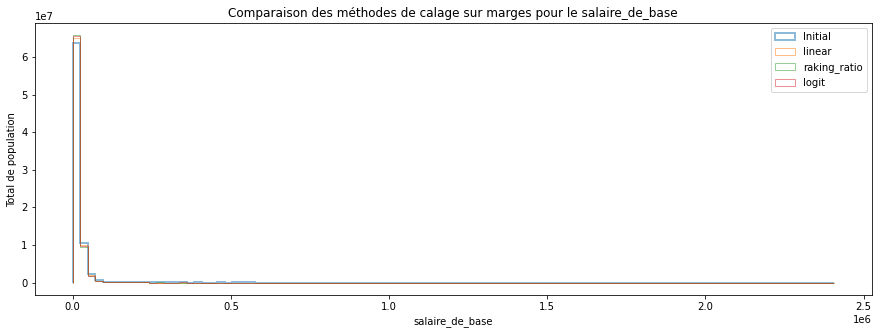

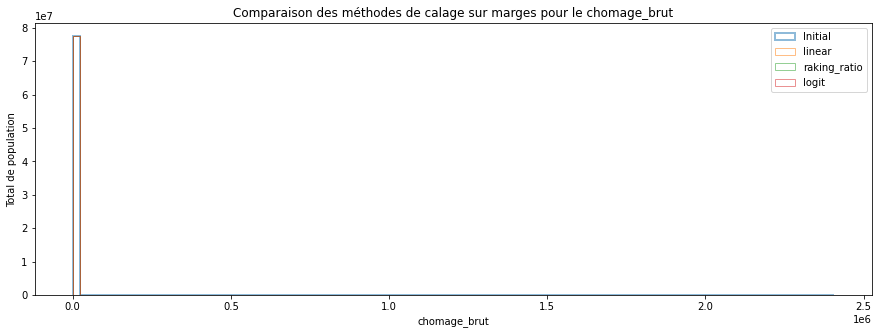

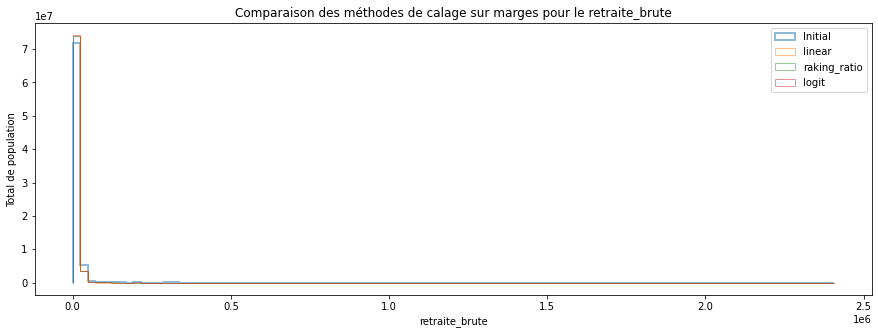

In [ ]:
# Distribution globale
plot_dict = calmar_hist(dataset, variables, wprm_init, results)

#### Distribution centrale

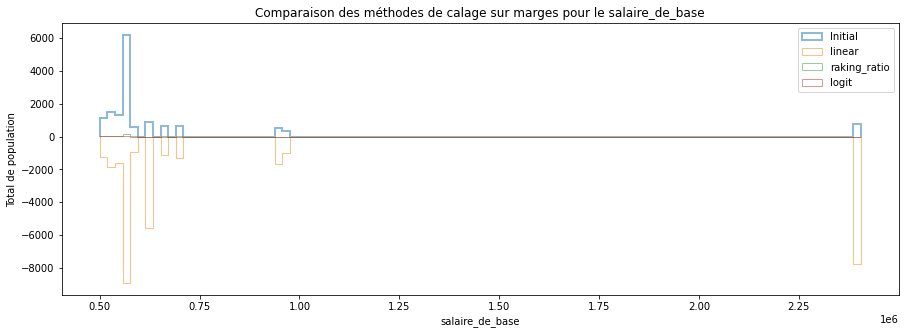

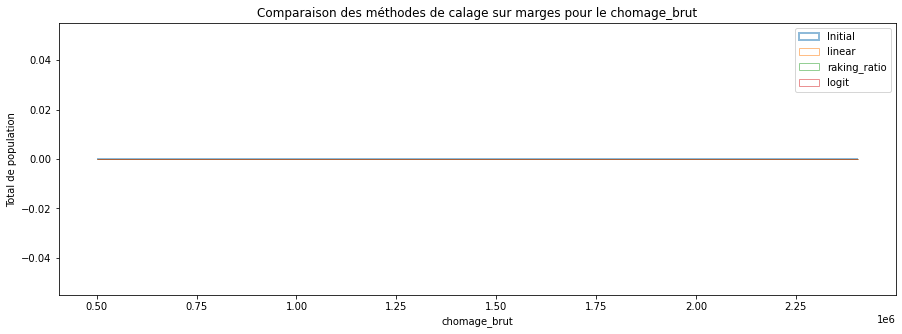

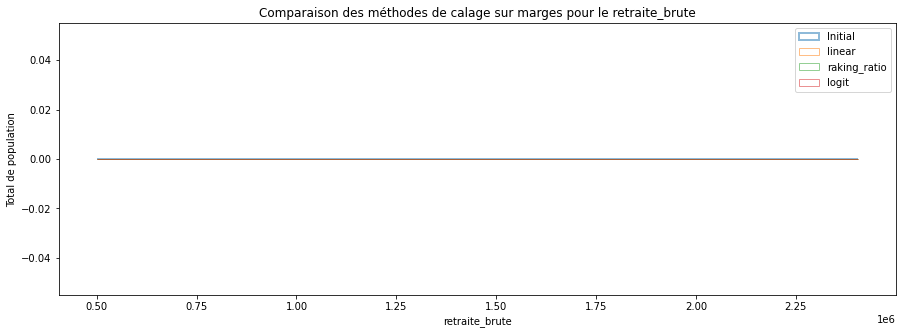

In [ ]:
# Distribution centrale
plot_dict_cent = calmar_hist(dataset, variables, wprm_init, results, min_=500_000)

#### Distribution hauts revenus

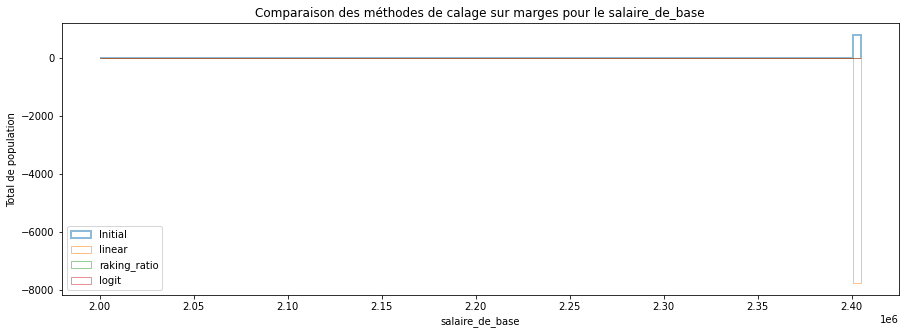

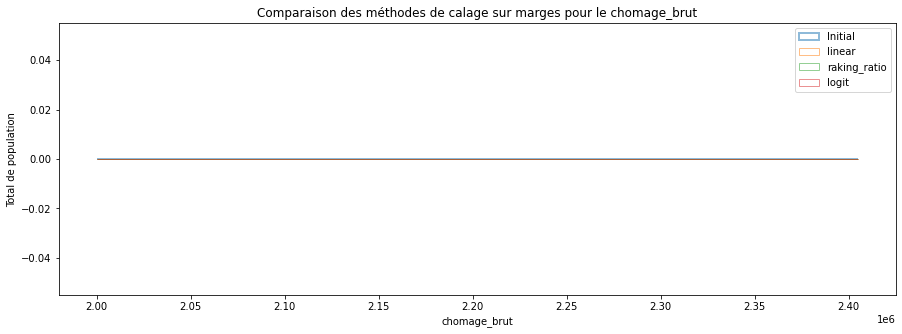

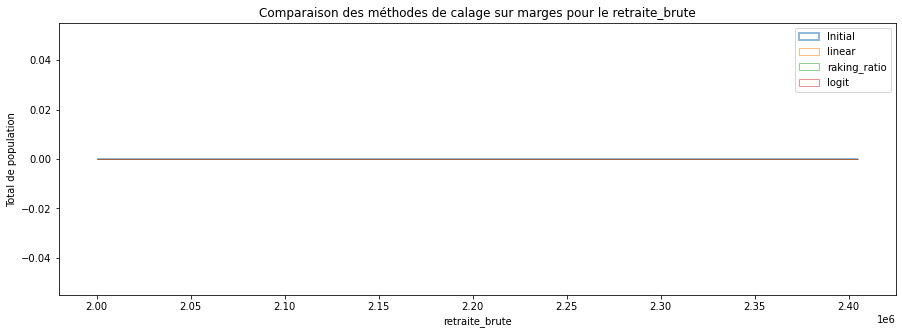

In [ ]:
# Distribution hauts revenus
plot_dict_hr = calmar_hist(dataset, variables, wprm_init, results, min_=2_000_000)

### Histogrammes comparatifs normés

On a du mal à visualiser les évolutions donc je normalise les paramètres

In [ ]:
def normalizer(dataset, variables):
    norm = {}
    for var in variables:
        mean_ = dataset[var].mean()
        std_ = dataset[var].std()

        dataset[var] = (dataset[var] - mean_) / std_

        norm.update({f"norm_{var}": [mean_, std_]})
        print(var, dataset[var].min(), dataset[var].max())

    return norm, dataset

In [ ]:
norm, datanorm = normalizer(dataset, variables)

salaire_de_base -0.4080933199288217 95.38477151311099
chomage_brut -0.18384354491217608 75.31924684230566
retraite_brute -0.4865721556158855 27.8441987544256


/tmp/ipykernel_25078/543608276.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[var] = (dataset[var] - mean_)/ std_


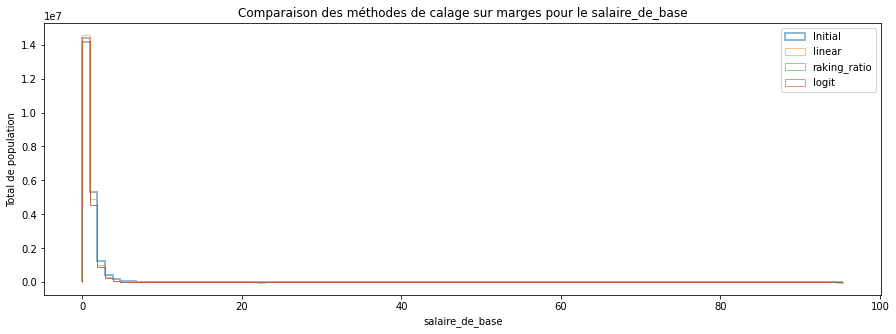

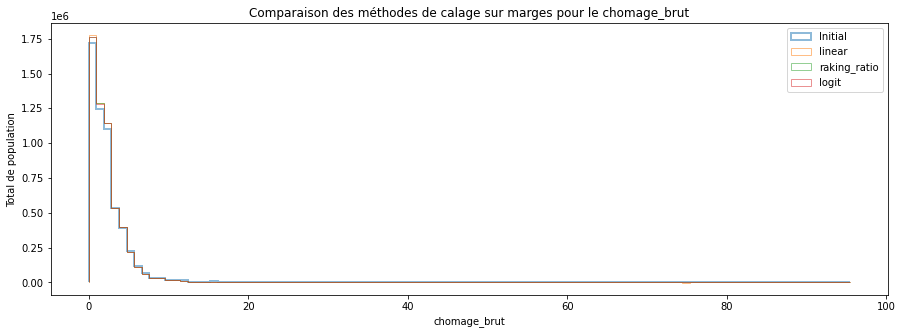

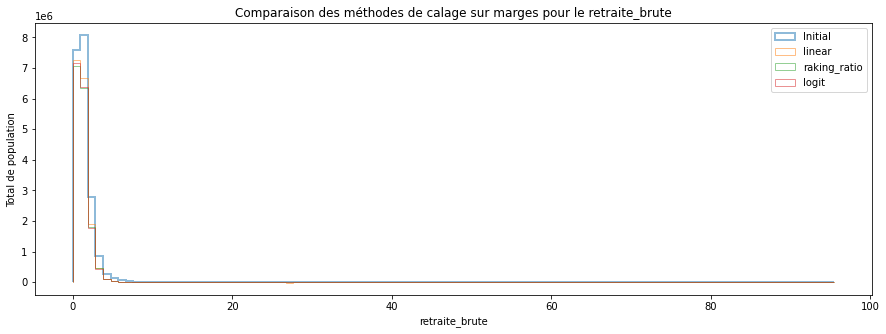

In [ ]:
plot_dict = calmar_hist(datanorm, variables, wprm_init, results, min_=0)

#### Distribution hauts revenus

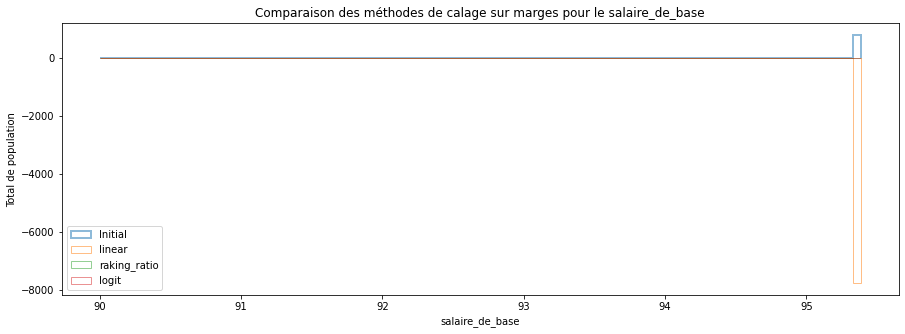

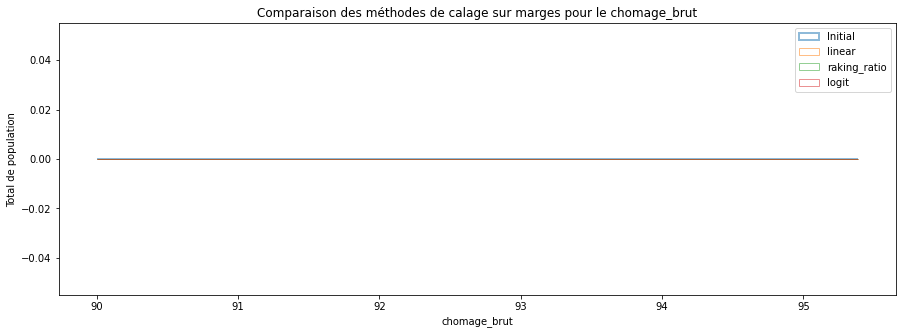

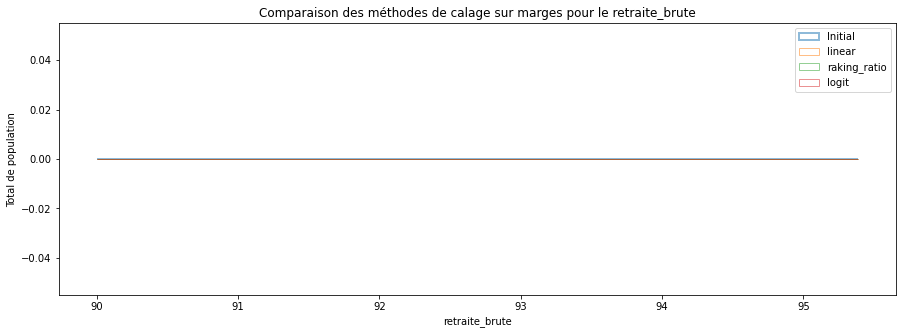

In [ ]:
plot_dict = calmar_hist(datanorm, variables, wprm_init, results, min_=90)

# Conclusion
Il semble que la méthode de calmar nous fasse disparaître les hauts revenus ? On regarde les poids


In [ ]:
var_to_check = "salaire_de_base"
analyse = dataset[[var_to_check, "wprm_init"]]
analyse["logit"] = pondfin_log
analyse["raking_ration"] = pondfin_rr
analyse["linear"] = pondfin_lin

analyse.sort_values(by=var_to_check, inplace=True)
analyse

/tmp/ipykernel_25078/2544165407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyse['logit'] = pondfin_log
/tmp/ipykernel_25078/2544165407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyse['raking_ration'] = pondfin_rr
/tmp/ipykernel_25078/2544165407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

salaire_de_base   wprm_init         logit  raking_ration       linear
0             -0.408093  272.745914  2.972860e+02   2.979264e+02   292.461829
170823        -0.408093  230.301305  2.671797e+02   2.689092e+02   258.800946
170824        -0.408093  230.301305  2.671797e+02   2.689092e+02   258.800946
170825        -0.408093  230.301305  2.671797e+02   2.689092e+02   258.800946
170826        -0.408093  230.301305  2.671797e+02   2.689092e+02   258.800946
...                 ...         ...           ...            ...          ...
274513        95.384772  258.597711  4.311411e-09   1.330349e-05 -2569.346273
337604        95.384772    1.214480  2.024814e-11   6.247860e-08   -12.066697
337488        95.384772    1.214480  2.024814e-11   6.247860e-08   -12.066697
50245         95.384772  258.597711  4.311411e-09   1.330349e-05 -2569.346273
162379        95.384772  258.597711  4.311411e-09   1.330349e-05 -2569.346273

[337808 rows x 5 columns]

In [ ]:
dataset

idfoy  quifoy   wprm_init  salaire_de_base  chomage_brut  \
0            0       0  272.745914        -0.408093     -0.183844   
1            1       0  227.157260        -0.408093     -0.183844   
2            1       1  227.157260        -0.408093     -0.183844   
3            2       0  194.930798         2.192474     -0.183844   
4            2       1  194.930798         0.755116     -0.183844   
...        ...     ...         ...              ...           ...   
337803  172206       0    0.668483         3.700387     -0.183844   
337804  172207       0    0.989284         8.755961     -0.183844   
337805  172208       0    0.693574         2.609549     -0.183844   
337806  172209       0    0.885337         3.336384     -0.183844   
337807  172210       0    0.793936         7.854549     -0.183844   

        retraite_brute      f4ba           rfr  
0            -0.171619       0.0  7.550002e+02  
1             1.226208       0.0  4.377800e+04  
2             2.010938       0.0  0.000000e+00  
3            -0.486572     550.0  7.019257e+04  
4            -0.486572       0.0  0.000000e+00  
...                ...       ...           ...  
337803       -0.486572    4399.0  3.186688e+07  
337804       -0.486572    1500.0  4.977271e+07  
337805        3.490158       0.0  9.158978e+07  
337806        7.439462  139340.0  6.888963e+07  
337807       -0.486572       0.0  5.150487e+07  

[337808 rows x 8 columns]

Next steps:

- Ajouter des hauts revenus AVANT la calibration
- Voir si un neural network ne permettrait pas une meilleure calibration
- Est-ce qu'un calage par buckets permettrait d'affiner la chose ? Mais alors il faut des buckets qui regroupent les gens pour toutes les variables confondues...

# Reunion Mahdi - 2022-01-26

Checks calmar:
   - ecart poids de calage vs poids de sondage
   - distribution des vars
  
  
Calage ERFS 2018 - POTE 2018 -> attention, ici on tire forcement la base dans une direction
Vieillissement 2019 -> est-ce que c'est pertinent ?
Insertion donnees Rk 2019
Calage avec POTE 2019 -> ca permet de tester la pertinence de nos procedures de vieillissement
Vieillissement -> 2021


Vieillissement: il faut adapter la distribution: parfois on a une nouvelle distribution (on adapte les var de l'inflation, le total de pop, mais aussi le nb de gens qui ont/n'ont pas le chomage/la retraite) -> on peut ajouter une cible (=indicatrice) "au chomage" en binaire pour caler sur cette nouvelle marge

Separer l'exercice:
- il faut avoir la vision economique de ce qu'on fait: quelles sont les indicatrices à utiliser (pour caler et/ou pour vieillir) ? On peut introduire des variables auxilliaires pour representer une distribution (i.e. plus d'infos que juste la somme totale)
- vieillissement != amelioration de la base
- il faut definir AVANT chaque etape les mesures de succes de cette operation

Etat de l'art (IPP)
- un travail sur la base initiale (appariemment et agregats)
- vieillissement : essentiellement (?) de l'inflation (les != types)
- voir pour recaler la pyramide des ages

Pour faire du calage en utilisant les buckets de POTE:
- on introduit des variables auxilliaires qui representent un bucket et on cale sur ces marges là


TO DO
- Faire tout en raking ratio et voir comment on parameterise la fonction (ecart de poids min et max)
- Lister nos variables: salaire brut, impot, prestations familiales
- Haut revenus : voir ce qu'il faut ajouter
